In [1]:
from __future__ import print_function
from fenics import *
from dolfin_adjoint import *
# import mshr
import numpy as np
import pathlib
from tqdm import tqdm

### Load created mesh

In [2]:
# Create mesh and define function space
sample_name = "AG03"
filepath = 'test_sample_deform/load/'+sample_name+'/'
out_dir = pathlib.Path(filepath)
out_dir.mkdir(parents=True, exist_ok=True)

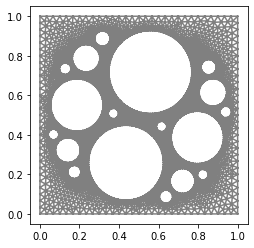

In [3]:
meshpath = './output_files/'
mesh = Mesh()
with XDMFFile(meshpath+sample_name+".xdmf") as xdmf_infile:
    xdmf_infile.read(mesh)
n_elements = mesh.coordinates().shape[0]
plot(mesh)

### Constitutive relation

In [4]:
# Mechanical Properties
E_m = 1e6
E = Constant(1*E_m)
nu = Constant(0.3)
sigma_y0 = Constant(0.01*E_m) # yield stress

mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
lmbda = 2*mu*lmbda/(lmbda+2*mu)

In [5]:
def sigmoid(x):
    s = 1/(1+exp(-x))
    return s
def tanh(x):
    t = (exp(2*x)-1)/(exp(2*x)+1)
    return t

In [6]:
# Constitutive relation
def epsilon(u):
    return sym(grad(u))

def sigma_el(epsilon):
    return lmbda*tr(epsilon)*Identity(2) + 2*mu*epsilon

def sigma_yield(epsilon):
    return sigma_y0 + 0.1*sigma_y0*tanh(epsilon*10)

def epsilon_pl(d_epsilon, sigma_old, epsilon_old,kappa_value=100):
    '''
    inputs
    d_epsilon: strain increment
    sigma_old: stress tensor at the increment n
    epsilon_old: plastic strain tensor
    kappa_value: sharpness of the sigmoid function
    '''
    kappa = Constant(kappa_value)
    
    sigma_y = sigma_yield(epsilon_old)
    H = diff(sigma_y, epsilon_old)
    
    sigma_pr = sigma_old + sigma_el(d_epsilon) # trial stress
    sigma_pr_dev = dev(sigma_pr) # deviatoric elastic stress
    sigma_ef = sqrt(3/2.*inner(sigma_pr_dev, sigma_pr_dev) + DOLFIN_EPS) # effective von Mises stress
    
    sgn = (sigma_ef - sigma_y)/(abs(sigma_ef - sigma_y) + DOLFIN_EPS)
    f_sigmoid = sigmoid(kappa*(sigma_ef - sigma_y)*sgn) # the indicator function
    f_ind = (f_sigmoid-0.5)*sgn + 0.5
    
    d_epsilon_pl_sc = f_ind*(sigma_ef - sigma_y)/(3*mu + H) # plastic strain increment (scalar)
    n_pr = dev(sigma_pr) / sigma_ef
    d_epsilon_pl = d_epsilon_pl_sc*3/2*n_pr
    
    return d_epsilon_pl

def Constitutive_function(sig_n, du, ep_n, dt=1E-3):
    d_epsilon_el = epsilon(du) # elastic strain increment
    d_epsilon_pl = epsilon_pl(d_epsilon_el,sig_n,ep_n) # plastic strain increment
    d_epsilon = d_epsilon_el - d_epsilon_pl
    dot_p = sqrt(inner(d_epsilon_pl,d_epsilon_pl)*2.0/3.0 + DOLFIN_EPS) #Accumulated plastic strain rate
    return sig_n + sigma_el(d_epsilon), dot_p

In [7]:
def mis_ep(u):
    eps_dev = epsilon(u) - Identity(2)*tr(epsilon(u))
    mis = sqrt(3/2*inner(eps_dev,eps_dev))
    return mis

def mis_sig(sig):
    sigma_dev = sig - Identity(2)*tr(sig)
    mis = sqrt(3/2*inner(sigma_dev,sigma_dev))
    return mis

In [8]:
Time = 40
num_steps = 40
e_tot = 0.01

def solve_plastic_system(mesh, Time, num_steps, constitutive_func, loss_func=lambda n,x: 0, tol = 1.0E-14):
    dt = Time / num_steps # time step size
    
    # Define function space for displacement
    S = FunctionSpace(mesh, 'P', 1)
    V = VectorFunctionSpace(mesh, 'P', 1)
    T = TensorFunctionSpace(mesh, 'P', 1)
    
    # Define test functions
    v  = TestFunction(V)
    du = TrialFunction(V)
    
    # Define functions for dsiplacement
    u     = Function(V)
    u_n   = Function(V)
    sig   = Function(T)
    sig_n = Function(T)
    ep    = Function(S)
    ep_n  = Function(S)

    # Define boundary 
    def BC_y0(x, on_boundary):
        return on_boundary and near(x[1], 0, tol)
    def BC_y1(x, on_boundary):
        return on_boundary and near(x[1], 1, tol)
    bcD = DirichletBC(V.sub(1), 0,    BC_y0)
    def BC_corner(x, on_boundary):
        return near(x[1], 0, tol) and near(x[0], 0, 5e-2)
    bc_corner = DirichletBC(V.sub(0), 0,    BC_corner)
    
    
    # Time-stepping
    t = 0
    results = []
    
    File_displacement = File(filepath+'displacement_AG.pvd')
    File_stress_Mis = File(filepath+'stress_Mis_AG.pvd')
    File_strain_Mis = File(filepath+'strain_Mis_AG.pvd')
    File_strain_AG = File(filepath+'strain_AG.pvd')
    File_stess_AG = File(filepath+'stess_AG.pvd')
    
    array_u = np.zeros((n_elements,2,num_steps+1))
    array_sigma = np.zeros((n_elements,2,2,num_steps+1))
    array_epsilon = np.zeros((n_elements,2,2,num_steps+1))
    
    for n in tqdm(range(num_steps+1)):
#         print(n)
        displacement = float(e_tot/num_steps*n)
        bcU = DirichletBC(V.sub(1), displacement, BC_y1)
        BC = [bcU, bcD, bc_corner]
        
        # Define variational problem
        sig, dep = constitutive_func(sig_n, u-u_n, ep_n, dt=dt)
        F = inner(sig, epsilon(v))*dx
        
        # Update current time
        t = t + dt
        
        # Solve variational problem for time step
        J = derivative(F, u, du)
        problem = NonlinearVariationalProblem(F, u, BC, J)
        solver = NonlinearVariationalSolver(problem)
        solver.solve()
        
        # Update previous solution
        sig = project(sig, T)
        ep = project(ep_n+dep, S)
        
        sig_n.assign(sig)
        u_n.assign(u)
        ep_n.assign(ep)
#         print('end')
        
        # Save solution to file in VTK format
        sig_Mis = project(mis_sig(sig),S)
        ep_Mis = project(mis_ep(u),S)
#         sig_Mis = mis_sig(sig)
#         ep_Mis = mis_ep(u)
        epsilon_u = epsilon(u)
        
        u.rename('$u$','displacement')
        sig.rename('$\sigma$','stress')
        ep.rename('$\epsilon$','strain')
        sig_Mis.rename('$\sigma_{VM}$','stress_Mis')
        ep_Mis.rename('$\epsilon_{VM}$','strain_Mis')
        
        File_displacement << (u,t)
        File_stress_Mis << (sig_Mis,t)
        File_strain_Mis << (ep_Mis)
        File_strain_AG << (ep,t)
        File_stess_AG << (sig,t)
        
        # Save element vectors in .mat format
        from scipy.io import savemat
        array_u[:,:,n] = np.array(u.vector()).reshape(n_elements,2)
        
        epsilon_u = epsilon(u)
        epsilon_u = project(epsilon(u),T)
        array_epsilon[:,:,:,n] = np.array(epsilon_u.vector()).reshape(n_elements,2,2)
        
        array_sigma[:,:,:,n] = np.array(sig.vector()).reshape(n_elements,2,2)
        
    mdic = {'u':array_u, 'epsilon':array_epsilon, 'sigma':array_sigma}
    savemat(filepath+'data.mat', mdic)
        
    return ep, sig, u, sig_Mis, ep_Mis

In [9]:
ep, sig, u, sig_Mis, ep_Mis = solve_plastic_system(mesh, Time, num_steps, Constitutive_function)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


  0%|          | 0/41 [00:00<?, ?it/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

100%|██████████| 41/41 [13:39<00:00, 19.99s/it]


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


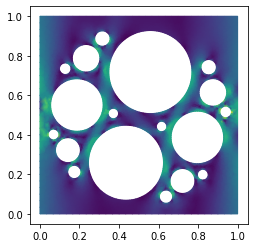

In [10]:
S = FunctionSpace(mesh, 'P', 2)
sigma_Mis = project(mis_sig(sig),S)
plot(sig_Mis, mode='color')